# "Concevez une application au service de la santé publique"
_Cleaning Notebook_
13/08 16h

## 0 Preliminaries

In [0]:
# # Creating/activating virtual environment and pipfile if not existing
# !pipenv install os
# !pip shell

### 0.0 Importing Packages and Modules

In [0]:
# # Importing requirements.txt file
# from google.colab import files
# files.upload()

In [0]:
# # Installing required packages
# !pipenv install

In [587]:
import sys
# Checking whether the notebook is on Colab or PC
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

In [588]:
# Replaced by 
# !pip install -r requirements.txt
# Installations and importations required for Google Colab version
if is_colab==True:
  from google.colab import files, output
  !pip install python-stdnum
  !pip install gTTS
  !pip install ipywidgets
else:
    pass

In [0]:
## IMPORTATIONS
import os
import io
import json
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
from stdnum.exceptions import *
from stdnum.util import *
from stdnum.ean import *
from ipywidgets import interact, interact_manual

In [0]:
# Function to display small dataframes side by side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),
                 raw=True)

In [0]:
# Setting pandas display options 
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 20,
                    'display.float_format': lambda x: '%.0f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

In [0]:
# To play audio text-to-speech during execution
from IPython.display import Audio
from gtts import gTTS

def speak(text):
    with io.BytesIO() as f:
        gTTS(text=text, lang='en').write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [593]:
speak('Packages and modules successfully imported')

### 0.1 Importing a sample of the dataset

In order to facilitate further manipulation of the dataset, we only upload a sample of the dataset at fisrt.

This will allow us to determine the best encoding form for each column therefore resulting in a better optimization of memory usage while uploading the full dataset.

In [594]:
p = 0.005  # reads 0.5% of the lines

if is_colab==False:
  # Importing database from the current Colab content directory
  df = pd.read_csv('../DATA/en.openfoodfacts.org.products.csv',
         header=0, sep='\t', low_memory=False, encoding ='utf-8',
         skiprows=lambda i: i>0 and np.random.random() > p)
  print("Imported from PC")
else:
  # Importing database from the Internet if not already in Colab environment
  if not os.path.exists('en.openfoodfacts.org.products.csv'):
    !wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
    print("Imported from the Internet in colab environment")
  else:
    pass
  df = pd.read_csv('/content/en.openfoodfacts.org.products.csv',
         header=0, sep='\t', low_memory=False, encoding ='utf-8',
         skiprows=lambda i: i>0 and np.random.random() > p)
  print("Imported from colab environment")

Imported from colab environment


In [595]:
speak('Dataset successfully imported')

### 0.2 Memory usage reduction

In order to facilitate the manipulation, we change the format of encoding
- ints and floats are to be downcasted
- objects are to be changed to category (if the number of unique values is less tha, half the number of rows)

NB: If we already know the format of data, we can specify the format of each column while loading the data in a pandas dataframe: *pd.read_csv('path', dtype=new_dtypes)*

In [596]:
## Changing format of object and float64 columns routine

new_dtypes = {}

# object -> category (if nb unique < half total nb of rows and not XXX_100g)
for col in df.columns.values:
    if df[col].dtype == 'object' :
      if len(df[col].unique()) / len(df[col]) < 0.5:
        new_dtypes[col] = 'category'
      else:
        new_dtypes[col] = 'object'

# float64 -> float32
for col in df.columns.values:
    if df[col].dtype == 'float64':
      if df[col].notna().sum()!=0: # 1% sample columns happening to be all null 
        new_dtypes[col] = 'float32'

# int64 -> int8
for col in df.columns.values:
    if df[col].dtype == 'int64':
        new_dtypes[col] = 'int8'
        
print(new_dtypes)

{'code': 'object', 'url': 'object', 'creator': 'category', 'created_datetime': 'object', 'last_modified_datetime': 'object', 'product_name': 'object', 'generic_name': 'category', 'quantity': 'category', 'packaging': 'category', 'packaging_tags': 'category', 'brands': 'category', 'brands_tags': 'category', 'categories': 'category', 'categories_tags': 'category', 'categories_en': 'category', 'origins': 'category', 'origins_tags': 'category', 'manufacturing_places': 'category', 'manufacturing_places_tags': 'category', 'labels': 'category', 'labels_tags': 'category', 'labels_en': 'category', 'emb_codes': 'category', 'emb_codes_tags': 'category', 'first_packaging_code_geo': 'category', 'cities_tags': 'category', 'purchase_places': 'category', 'stores': 'category', 'countries': 'category', 'countries_tags': 'category', 'countries_en': 'category', 'ingredients_text': 'category', 'allergens': 'category', 'traces': 'category', 'traces_tags': 'category', 'traces_en': 'category', 'serving_size': 

In [0]:
## Forcing XXX_100g columns to 'float32'
X_100g_cols = df.columns[df.columns.str.contains('_100g')]
df[X_100g_cols] = df[X_100g_cols].astype('float32')

In [598]:
# Importing the whole dataframe with optimized types

if is_colab==False:
  # Importing database from my current local Git Repo
  df = pd.read_csv('../DATA/en.openfoodfacts.org.products.csv', dtype=new_dtypes,
         header=0, sep='\t', low_memory=False, encoding ='utf-8')
  print("Imported from PC")
else:
  df = pd.read_csv('/content/en.openfoodfacts.org.products.csv', dtype=new_dtypes,
         header=0, sep='\t', low_memory=False, encoding ='utf-8')
  print("Imported from colab environment")

Imported from colab environment


In [599]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366025 entries, 0 to 1366024
Columns: 181 entries, code to carnitine_100g
dtypes: category(49), float32(76), float64(46), int8(2), object(8)
memory usage: 2.7 GB


In [600]:
speak("Reduction of memory usage done")

Main conclusions : 
- Description :
  954463 rows and 175 columns
  some of them categorical, 
  some of them numerical
- Memory usage reduction : 
  6.0 GB -> 2.2 GB

### 0.3 First Overview

In [601]:
# Shape of the dataset
df_sh = df.shape # (1173417, 178) (954463, 175)
df_sh

(1366025, 181)

In [602]:
# General description 
desc = df.describe(include='all')

# Types and content of the columns
desc_type = pd.DataFrame(df.dtypes, columns=['type']).T
nb_Null = (df_sh[0]-desc.loc["count"].T)
pct_null = (df_sh[0]-desc.loc["count"].T)*100/df_sh[0]
desc_null = pd.DataFrame([nb_Null, pct_null], index=['nb null','pct null'])

# Concatenate general, type and null stats
desc = pd.concat([desc_type, desc_null, desc])
desc

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,object,object,category,int8,object,int8,object,object,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,float64,category,category,category,category,category,category,category,category,float64,category,category,category,...,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float32,float64,float64,float64
nb null,0,0,4,0,0,0,0,60100,1264308,979449,1149925,1149934,595718,595768,649209,649212,649212,1306114,1306214,1270709,1270746,1043775,1043752,1043752,1272254,1272281,1305813,1366025,1301137,1232279,1167662,2121,2123,2123,743263,1205027,1366025,1290561,1269649,1269649,...,1357602,1354061,1365127,1360285,1365921,1365697,1274872,1365424,1098088,1352707,1102439,1351873,1356178,1361876,1362112,1365747,1363670,1365877,1365822,1364102,1365672,1365903,1365875,1359815,1365731,1354910,1365728,1360787,1366023,1365606,1355825,804058,1365981,1366022,1366025,1365988,1364316,1366002,1365986,1366008
pct null,0,0,0,0,0,0,0,4,93,72,84,84,44,44,48,48,48,96,96,93,93,76,76,76,93,93,96,100,95,90,85,0,0,0,54,88,100,94,93,93,...,99,99,100,100,100,100,93,100,80,99,81,99,99,100,100,100,100,100,100,100,100,100,100,100,100,99,100,100,100,100,99,59,100,100,100,100,100,100,100,100
count,1366025,1366025,1366021,1366025,1366025,1366025,1366025,1305925,101717,386576,216100,216091,770307,770257,716816,716813,716813,59911,59811,95316,95279,322250,322273,322273,93771,93744,60212,0,64888,133746,198363,1363904,1363902,1363902,622762,160998,0,75464,96376,96376,...,8423,11964,898,5740,104,328,91153,601,267937,13318,263586,14152,9847,4149,3913,278,2355,148,203,1923,353,122,150,6210,294,11115,297,5238,2,419,10200,561967,44,3,0,37,1709,23,39,17
unique,1365781,1365861,11005,NaN,1119319,NaN,980483,881149,74587,31241,37745,30524,133310,105557,91436,54720,54720,10326,9113,21647,19581,58697,43623,43623,25686,22869,3364,NaN,6249,9836,11838,8087,2972,2972,517368,5761,NaN,8890,8972,8972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0211992120243,http://world-en....,kiliweb,NaN,2020-04-23T17:22...,NaN,2019-03-16T21:14...,Aceite de oliva ...,Ice cream,500 g,"sachet,plastique","sachet,plastique",Carrefour,carrefour,Snacks,en:snacks,Snacks,France,france,France,france,en:gluten-free,en:organic,Organic,FSC-C014047,fsc-c014047,"47.833333,-0.333333",NaN,sable-sur-sarthe...,France,Carrefour,France,en:france,France,Carbonated

In [603]:
print(tuple(df.columns.values))

('code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', '

14 columns with no entry, no row has all the columns filled.

In [604]:
speak('Description overview done')

Main conclusions : 

## 1 Feature selection

### 1.1 Filtering out non relevant columns
Some columns can immediately be classified as non useful for our project and therefore dropped : 
- 5 columns concerning to the image of the product: 'image_small_url',	'image_ingredients_url',	'image_ingredients_small_url',	'image_nutrition_url'	'image_nutrition_small_url'
- 3 columns concerning the level of completion of the row: 'states', 'states_tags', 'states_en' 


In [605]:
li_col_del = ['image_url', 'image_small_url',	'image_ingredients_url',
              'image_ingredients_small_url',	'image_nutrition_url',
              'image_nutrition_small_url',
              'states', 'states_tags', 'states_en' ]
# Filtering out 8 non relevant columns
df.drop(columns=li_col_del, inplace=True)
df.shape

(1366025, 172)

### 1.2 Almost empty columns

Let's see how the columns are filled.


In [606]:
# Checking nb of not null values in the columns
nb_not_null = pd.DataFrame((~df.isna()).sum(axis =0), columns=['nb'])
nb_not_null.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
nb_not_null.T.head(150)

,ingredients_from_palm_oil,-mead-acid_100g,-gondoic-acid_100g,-elaidic-acid_100g,ingredients_that_may_be_from_palm_oil,cities,-melissic-acid_100g,-erucic-acid_100g,-lignoceric-acid_100g,allergens_en,water-hardness_100g,-caproic-acid_100g,no_nutriments,-nervonic-acid_100g,-myristic-acid_100g,-caprylic-acid_100g,-stearic-acid_100g,-dihomo-gamma-linolenic-acid_100g,-butyric-acid_100g,chlorophyl_100g,-montanic-acid_100g,glycemic-index_100g,-palmitic-acid_100g,-cerotic-acid_100g,-capric-acid_100g,-gamma-linolenic-acid_100g,-behenic-acid_100g,-maltose_100g,-lauric-acid_100g,nucleotides_100g,carnitine_100g,-maltodextrins_100g,-oleic-acid_100g,beta-glucan_100g,-arachidic-acid_100g,additives,-arachidonic-acid_100g,serum-proteins_100g,choline_100g,inositol_100g,...,serving_size,serving_quantity,fiber_100g,nova_group,nutriscore_grade,nutriscore_score,nutrition-score-fr_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ingredients_text,main_category,main_category_en,categories_en,categories_tags,categories,brands_tags,brands,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,salt_100g,carbohydrates_100g,fat_100g,proteins_100g,energy_100g,product_name,pnns_groups_1,countries_en,countries_tags,countries,pnns_groups_2,creator,last_modified_datetime,last_modified_t,created_datetime,created_t,url,code
nb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,3,3,3,4,5,7,9,9,13,17,17,22,23,24,29,30,36,37,39,...,433371,433620,437138,536014,561958,561958,561967,622754,622754,622754,622762,716813,716813,716813,716813,716816,770257,770307,1034219,1051111,1077763,1083472,1083480,1098365,1098919,1100318,1106149,1305925,1352279,1363902,1363902,1363904,1365532,1366021,1366025,1366025,1366025,1366025,1366025,1366025


In [607]:
# Displaying a table with bins
mask = pd.cut(nb_not_null['nb'], [-1,0,5,10,100,300,1000000]) # 
mask.value_counts(normalize=False, sort=False)

(-1, 0]           14
(0, 5]            12
(5, 10]            3
(10, 100]         17
(100, 300]        12
(300, 1000000]    92
Name: nb, dtype: int64

In [608]:
# Plotting nb of not null per column
@interact_manual
def plot_more_than_n_notna(n =(1,1000,50)):
   ax = nb_not_null['nb'][nb_not_null['nb']>n].reset_index()\
                .plot.bar(x='index', y='nb', figsize=(25,4))
   ax.set(yscale='log')
   return ax

interactive(children=(IntSlider(value=451, description='n', max=1000, min=1, step=50), Button(description='Run…

In [609]:
# Displaying names of columns with less than 300 entries
mask = pd.cut(nb_not_null['nb'], [-1,300])
li_col_del = list(mask[~mask.values.isna()].index)
print(len(li_col_del))
for s in li_col_del:
  print(s, end='|')

58
ingredients_from_palm_oil|-mead-acid_100g|-gondoic-acid_100g|-elaidic-acid_100g|ingredients_that_may_be_from_palm_oil|cities|-melissic-acid_100g|-erucic-acid_100g|-lignoceric-acid_100g|allergens_en|water-hardness_100g|-caproic-acid_100g|no_nutriments|-nervonic-acid_100g|-myristic-acid_100g|-caprylic-acid_100g|-stearic-acid_100g|-dihomo-gamma-linolenic-acid_100g|-butyric-acid_100g|chlorophyl_100g|-montanic-acid_100g|glycemic-index_100g|-palmitic-acid_100g|-cerotic-acid_100g|-capric-acid_100g|-gamma-linolenic-acid_100g|-behenic-acid_100g|-maltose_100g|-lauric-acid_100g|nucleotides_100g|carnitine_100g|-maltodextrins_100g|-oleic-acid_100g|beta-glucan_100g|-arachidic-acid_100g|additives|-arachidonic-acid_100g|serum-proteins_100g|choline_100g|inositol_100g|casein_100g|nutrition-score-uk_100g|omega-9-fat_100g|-glucose_100g|beta-carotene_100g|-fructose_100g|silica_100g|-eicosapentaenoic-acid_100g|-sucrose_100g|taurine_100g|-docosahexaenoic-acid_100g|chromium_100g|ph_100g|-linoleic-acid_100g

In [610]:
# Printing remaining columns
li_rem_col = [s for s in list(df.columns) if s not in li_col_del]
print(len(li_col_del))
for s in li_rem_col:
  print(s, end='|')

58
code|url|creator|created_t|created_datetime|last_modified_t|last_modified_datetime|product_name|generic_name|quantity|packaging|packaging_tags|brands|brands_tags|categories|categories_tags|categories_en|origins|origins_tags|manufacturing_places|manufacturing_places_tags|labels|labels_tags|labels_en|emb_codes|emb_codes_tags|first_packaging_code_geo|cities_tags|purchase_places|stores|countries|countries_tags|countries_en|ingredients_text|allergens|traces|traces_tags|traces_en|serving_size|serving_quantity|additives_n|additives_tags|additives_en|ingredients_from_palm_oil_n|ingredients_from_palm_oil_tags|ingredients_that_may_be_from_palm_oil_n|ingredients_that_may_be_from_palm_oil_tags|nutriscore_score|nutriscore_grade|nova_group|pnns_groups_1|pnns_groups_2|brand_owner|main_category|main_category_en|energy-kj_100g|energy-kcal_100g|energy_100g|energy-from-fat_100g|fat_100g|saturated-fat_100g|monounsaturated-fat_100g|polyunsaturated-fat_100g|omega-3-fat_100g|-alpha-linolenic-acid_100g|ome

We keep columns with more than 300 values except:
- 'carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g',
'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g', as they would require more data to be exploitable.

In [611]:
# Adding 4 columns from the "to-be-deleted" columns list 
li_col_del += ['carbon-footprint_100g',
               'carbon-footprint-from-meat-or-fish_100g',
               'fruits-vegetables-nuts_100g',
               'fruits-vegetables-nuts-estimate_100g']
print(f'nb of columns to drop: {len(li_col_del)}')

nb of columns to drop: 62


In [612]:
print("shape before", df.shape)
df.drop(columns=li_col_del, inplace=True)
print("shape after", df.shape)

shape before (1366025, 172)
shape after (1366025, 110)


We rearrange the columns with similar contents at the same place:

In [0]:
# Changing the name of some of the columns
df.rename(columns={'nutriscore_score': 'nutriscore',
                       'nutriscore_grade': 'nutrigrade',
                       'pnns_groups_1': 'pnns_gp_1',
                       'pnns_groups_2': 'pnns_gp_2',
                       'nutrition-score-fr_100g':'nutriscore-fr'},
              inplace=True)

In [0]:
# Function that moves similar names in an Index at the same place
def move_cat_containing(my_index, strings, order):

  idx_sel = []

  if order == 'last':
    index = my_index
  elif order == 'first':
    index = my_index[::-1]
  else:
    print("--- WARNING : index unchanged.\n -- Wrong order passed. Pass 'first' or 'last'")
    return my_index

  for s in strings:
    idx_sel += [i for i,x in enumerate(index) if x in index[index.str.contains(s)]]
  to_move = index[idx_sel]
  rank = max(idx_sel)
  mod_index = index.drop(to_move)
  for c in to_move:
    mod_index = mod_index.insert(rank,c)
  
  return mod_index if order=='last' else mod_index[::-1]

In [615]:
# Moving 'nutriscores', 'categories', info related to brand and to quantities
cols = df.columns
cols = move_cat_containing(cols,['name'], 'first')
cols = move_cat_containing(cols,['brand'], 'first')
cols = move_cat_containing(cols,['categ','pnns', 'label'], 'first')
cols = move_cat_containing(cols,['nutri', 'nova'], 'first')
cols = move_cat_containing(cols,['_100g'], 'last')
print(tuple(cols))

('code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'main_category_en', 'main_category', 'categories_en', 'categories_tags', 'categories', 'pnns_gp_2', 'pnns_gp_1', 'labels_en', 'labels_tags', 'labels', 'generic_name', 'product_name', 'last_modified_datetime', 'quantity', 'brand_owner', 'brands_tags', 'brands', 'packaging', 'packaging_tags', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'additives_n', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'nutriscore-fr', 'nutrigrade', 'nutriscore', 'nova_group', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'energy-kj_100g', 'energy-kcal

In [616]:
df = df.reindex(columns=cols)
df.head(1)

,code,url,creator,created_t,created_datetime,last_modified_t,main_category_en,main_category,categories_en,categories_tags,categories,pnns_gp_2,pnns_gp_1,labels_en,labels_tags,labels,generic_name,product_name,last_modified_datetime,quantity,brand_owner,brands_tags,brands,packaging,packaging_tags,origins,origins_tags,manufacturing_places,manufacturing_places_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,...,sugars_100g,-lactose_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,caffeine_100g,cocoa_100g,phylloquinone_100g
0,0000000000017,http://world-en....,kiliweb,8,2018-06-15T10:38...,-90,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,Vitória crackers,2019-06-25T11:55...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,...,15,nan,nan,nan,nan,nan,nan,8,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### 1.3 Columns with redundant information

Some of the columns seem to contain similar information. For example : 
  - 'created_t' vs.	'created_datetime'
  - 'last_modified_t' vs.	'last_modified_datetime'
  - 'brands' vs.	'brands_tags'
  - 'categories	' vs.	'categories_tags'  vs.	'categories_en'  
  - 'origins' vs.	'origins_tags'
  - 'manufacturing_places' vs.	'manufacturing_places_tags'
  - 'labels' vs.	'labels_tags'  vs.	'labels_en' 
  - 'emb_codes' vs.	'emb_codes_tags'
  - 'countries' vs.	'countries_tags'  vs.	'countries_en'
  - 'traces' vs.	'traces_tags'  vs.	'traces_en'
  - 'additives_n' vs. 'additives' vs.	'additives_tags'  vs.	'additives_en'


Let's see if some of them can be dropped or their content gathered in only one column.
To that end, we define a function '**comp_df**' that :
- compares the content of two columns col1 and col2 of the dataframe
- prints the number or rows with 1) both columns, 2) col1 only, 3) col2 only, and 4) none of them filled
- returns indexes of 1) data in both columns, 2) data only in col1, 3) data only in col2, and 4) no data at all.

After that, we check and compare the content of the columns when both are filled in order to get familiar with the content of the database and determine the columns that can be dropped.

In [0]:
def comp_df (df, col1, col2, print_Y_N):
  m_both = (~df[[col1,col2]].isna()).sum(axis=1)==2 # mask for both cells filled
  m_one = (~df[[col1,col2]].isna()).sum(axis=1)==1 # mask for only one cell filled
  m_col1 = m_one & ~df[col1].isna() # mask for only col1 cell filled
  m_col2 = m_one & ~df[col2].isna() # mask for only col2 cell filled
  mnone = ~m_one & ~m_both
  ind_both = df.index[m_both].to_list()
  ind_col1 = df.index[m_col1].to_list()
  ind_col2 = df.index[m_col2].to_list()
  ind_none = df.index[mnone].to_list()
  if print_Y_N :
    print("nb rows both filled: ", len(ind_both))
    print("nb rows with only", col1, "filled: ", len(ind_col1))
    print("nb rows with only", col2, "filled: ", len(ind_col2))
    print("nb rows not filled: ", len(ind_none))
  else:
    pass
  return(ind_both, ind_col1, ind_col2, ind_none)

In [618]:
# Printing amount of rows in each case:
#(col1 filled, col2 filled, both filled, none filled)
li_col = ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places',
        'labels', 'emb_codes','countries', 'traces']
for c in li_col:
  c1 = c
  c2 = c+'_tags'
  print('COLUMN', c,':')
  t_ind = comp_df(df, c1, c2, True)
  df.loc[t_ind[1], [c1,c2]] = np.nan

COLUMN packaging :
nb rows both filled:  216089
nb rows with only packaging filled:  11
nb rows with only packaging_tags filled:  2
nb rows not filled:  1149923
COLUMN brands :
nb rows both filled:  770249
nb rows with only brands filled:  58
nb rows with only brands_tags filled:  8
nb rows not filled:  595710
COLUMN categories :
nb rows both filled:  716813
nb rows with only categories filled:  3
nb rows with only categories_tags filled:  0
nb rows not filled:  649209
COLUMN origins :
nb rows both filled:  59808
nb rows with only origins filled:  103
nb rows with only origins_tags filled:  3
nb rows not filled:  1306111
COLUMN manufacturing_places :
nb rows both filled:  95279
nb rows with only manufacturing_places filled:  37
nb rows with only manufacturing_places_tags filled:  0
nb rows not filled:  1270709
COLUMN labels :
nb rows both filled:  322232
nb rows with only labels filled:  18
nb rows with only labels_tags filled:  41
nb rows not filled:  1043734
COLUMN emb_codes :
nb row

We design an interactive feature that helps browsing the data and compare the content of XXX AND XXX_tags columns :

In [619]:
@interact_manual
def print_comp_info(col=li_col):
  c1 = col
  c2 = c1+'_tags'
  # Comparing content of 2 columns, print info and returns indexes 
  t_ind = comp_df(df, c1, c2, True)
  # Displaying a random sample of cells:
  '''- when col1 only is filled
  - when col2 only is filled
  - when both columns are filled'''
  display_side_by_side(df.loc[t_ind[1],[c1, c2]]\
                       .sample(5 if len(t_ind[1])>5 else len(t_ind[1])),
                      df.loc[t_ind[2], [c1, c2]]\
                       .sample(5 if len(t_ind[2])>5 else len(t_ind[2])),
                      df.loc[t_ind[0], [c1, c2]]\
                       .sample(5 if len(t_ind[0])>5 else len(t_ind[0])))

interactive(children=(Dropdown(description='col', options=('packaging', 'brands', 'categories', 'origins', 'ma…

After examination of all the columns above-listed, we decide :
- to set values of the 'XXX' column to NaN if not matching with a non NaN value in the 'XXX_tags' column (as we found that they correspond to erroneous values ('?', '/', '-', etc.));
- to drop 'created_t' and 'last_modified_t';
- to drop 'packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'countries_tags', 'additives_tags', as the data they contain are redundant with 'XXX' or 'XXX_en' columns;
- to drop 'traces' (instead of 'traces_tags'), as it is less filled then 'traces_tags'
- to drop 'additives' column, as it does not contain enough data (29 entries), that are however in english in 'additives_en'
- to keep 'XXX_en' columns, as they contain useful and sometimes original data;
- to keep 'XXX' columns.

In [0]:
# Setting values of the 'XXX' column to NaN if no value in 'XXX_tag' 
t_ind = comp_df(df, c1, c2, False)
df.loc[t_ind[1], [c1,c2]] = np.nan

In [621]:
# Dropping unuseful columns
li_col_del = ['created_t', 'last_modified_t','packaging_tags',
             'brands_tags', 'categories_tags', 'origins_tags', 
             'manufacturing_places_tags', 'labels_tags',
             'emb_codes_tags','countries_tags', 'traces',
             'additives_tags']
print("shape before", df.shape)
df.drop(columns=li_col_del, inplace=True)
print("shape after", df.shape)

shape before (1366025, 110)
shape after (1366025, 98)


In [622]:
# Checking the remaining columns
print(tuple(df.columns))

('code', 'url', 'creator', 'created_datetime', 'main_category_en', 'main_category', 'categories_en', 'categories', 'pnns_gp_2', 'pnns_gp_1', 'labels_en', 'labels', 'generic_name', 'product_name', 'last_modified_datetime', 'quantity', 'brand_owner', 'brands', 'packaging', 'origins', 'manufacturing_places', 'emb_codes', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_en', 'ingredients_text', 'allergens', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'additives_n', 'additives_en', 'ingredients_from_palm_oil_n', 'nutriscore-fr', 'nutrigrade', 'nutriscore', 'nova_group', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', '-alpha-linolenic-acid_100g', 'omega-6-fat_100g', '

Some columns are related and provide information useful to retrieve data via feature engineering.
To help automatizing these tasks, we categorize the columns as follows :

**li_cat_fat**: 'saturated_fat_100g', 'monounsaturated_fat_100g', 'polyunsaturated_fat_100g', 'trans-fat_100g', 'cholesterol_100g'

**li_cat_poly_fat**: 'omega-3-fat_100g', 'omega-6-fat_100g'

**li_cat_carb**: 'sugars_100g', 'starch_100g', 'polyols_100g', 'fibers_100g', '-lactose_100g'

**li_cat_comp**: cat_fat, cat_carb, 'proteins_100g'

**li_cat_vit-oligo**:  'vitamin-a_100g',	'vitamin-d_100g',	'vitamin-e_100g',	'vitamin-k_100g',	'vitamin-c_100g',	'vitamin-b1_100g',	'vitamin-b2_100g',	'vitamin-pp_100g',	'vitamin-b6_100g',	'vitamin-b9_100g',	'folates_100g',	'vitamin-b12_100g',	'biotin_100g',	'pantothenic-acid_100g','silica_100g', 'bicarbonate_100g',	'potassium_100g',	'chloride_100g',	'calcium_100g',	'phosphorus_100g',	'iron_100g',	'magnesium_100g',	'zinc_100g',	'copper_100g',	'manganese_100g',	'fluoride_100g', 'selenium_100g, 'chromium_100g', 'molybdenum_100g', 'iodine_100g',	'caffeine_100g', 'taurine_100g', 'cocoa_100g'

In [623]:
speak('Filtered out unmeaningful columns')

## 2 Dealing with missing or erroneous data

### 2.1 'product_name' column

In [0]:
# Replacing invalid names (1 or 0 characters) with np.NaN
df.loc[df[df['product_name'].str.len()<2].index,'product_name'] = np.nan

### 2.2 'code' column

Let's first check the 'code' column for completion and validity of the data:

In [625]:
# Checking nb of null values in 'code' column
df['code'].isna().sum()

0

No null value in the 'code' column.

We will now create a new column 'code_val' indicating if the barcode is valid.

In [626]:
# Verification of barcodes (EAN-13, EAN-8 and UPC (12-digit) format)
# Creation of a new column : 'code_val' (bool) barcode valid or not
df.insert(1,'code_val', df['code'].apply(is_valid))
print("nb of valid codes: ", df['code_val'].sum())
print("nb of invalid codes: ", (~df['code_val']).sum())
print("pctage of valid codes: {:.2f}%".format(df['code_val'].sum()*100/df.shape[0]))

nb of valid codes:  1335855
nb of invalid codes:  30170
pctage of valid codes: 97.79%


### 2.3 'quantity' column

In [0]:
# Changing the type of quantity column from 'category' to 'quantity'
df['quantity'] = df['quantity'].astype('object')

In [0]:
# Function selecting the most relevant tuple (num,unit) in the list
# by order of priority : unit in li_prio1, then in li_prio2

def sel_gr(li, li_prio1, li_prio2):
  res = 0
  nums, units = li
  tab_t_u = []
  ind = np.nan
  for i in units:
    if  i in li_prio1:
      tab_t_u.append(2)
    elif  i in li_prio2:
      tab_t_u.append(1)
    else:
      tab_t_u.append(0) if i!='' else tab_t_u.append(np.nan)
  i_tab1 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==2] # indexes of all volumes (prio1)
  i_tab2 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==1] # indexes of all masses (prio2)
  i_tab0 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==0] # indexes of all others (prio3)
  if len(i_tab1)>0: # prio1 (vol)
    ind = i_tab1[np.argmax([nums[i] for i in i_tab1])]
  elif len(i_tab2)>0: # prio2 (mass)
    ind = i_tab2[np.argmax([nums[i] for i in i_tab2])]
  else:
    ind = i_tab0[np.argmax([nums[i] for i in i_tab0])] if len(i_tab0)>0 else np.nan
  return(nums[ind], units[ind]) if ind is not np.nan else (np.nan, np.nan)

In [631]:
# Creating a new database with 'quantity' data (wo null, same index)
df_q = df['quantity'].dropna().to_frame()
print("Nb of notna values in 'quantity': {} on {}, i.e. {:.1f}%"\
           .format(df_q.shape[0], df.shape[0],df_q.shape[0]*100/df.shape[0]))
display(df_q.head(15).T)

Nb of notna values in 'quantity': 386576 on 1366025, i.e. 28.3%


,1,3,4,18,40,50,64,96,99,120,153,157,158,160,162
quantity,130 g,100g,dgesc,80 g,1kg,4 g,1,500 g,120g,Vrac,250 ml,2.46 kg,230g,100 g,60 capsules


Then we design routines that will be used to extract from the 'quantity' column :
- all numerical values
- all possible corresponding units

In [0]:
'''Cleaning 'quantity' column routines''' 

# To ensure safe execution of function 'float'
def safe_exe(def_val, function, *args):
    try: return function(*args)
    except: return def_val

# Conversion of string in float if possible, else 0 (accepts 'n1 x n2' string)
def conv_float(my_str):
  idx = 0
  if 'x' in my_str:
    idx = my_str.find('x')
    n1 = safe_exe(0, float, my_str[:idx])
    n2 = safe_exe(0, float, my_str[idx+1:])
    return n1*n2
  else:
    return safe_exe(0, float, my_str)

# Splits string in a list of tuples (number, associated unit)
def num_units(my_str):
  my_str = my_str.lower().strip()
  regex = r'([0-9.,x ]*)\s*([^()0-9 !,\-±=\*\+/.-\?\[\]]*\s*)'
  res = re.findall(regex, my_str)
  res.remove(('', ''))
  num = [conv_float(gr[0].replace(' ','').replace(',','.')) for gr in res]
  unit = [gr[1].strip()  for gr in res]
  res=list(zip(num,unit))
  return num, unit

We manually make a selection among the unique values of units of denominations of mass units and volume units.

In [0]:
# Classifying main relevant units in 'mass' and 'volume' units
li_u_mass = ['g', 'kg', 'gr', 'grammes', 'grs','st', 'mg', 'gramm', 'lb','gram',
             'grams', 'gramos', 'lbs', 'gm', 'lt', 'lts','gramme', 'kilo','公克',
             'grammi', 'kgs', 'kgr', 'gms', 'g-', 'grms','pound', 'pounds', 
             'grm', 'grames','غرام', 'جرام','غ', 'غم','جم','g℮', 'г', 'кг', '克', 
             'грамм', 'גרם','kilogramm','gramas','kilogrammae','livres',
             'grame', 'kilos'] 
li_u_vol = ['ml','dl','l','cl', 'oz', 'litre', 'fl', 'litres', 'liter','litro',
            'litri','litr', 'ounces','ounce', 'ltr', 'gallon','half-gallon',
            'litros','litroe', 'liters', 'cc', 'kl', 'pint','pints', 'gal',
            'mls', 'centilitres', 'لتر','مل','ل','ليتر', 'มล', 'ลิตร', 'мл', 'л',
            'litrè', 'milliliter','millilitre', 'γρ', 'литр', 'литра', 'mml',
            'מ״ל','millilitres','λίτρο', 'mĺ', 'cm', 'cm³' ]

Let's apply these functions to the 'quantity' column:

In [638]:
# Splitting numerical and unit values in two new columns
df_q['analysis'] = df_q['quantity'].apply(num_units)
df_q[['num_gr','unit_gr']] = pd.DataFrame(df_q['analysis'].tolist(),
                                          index=df_q['analysis'].index)
# Selecting the main (num, unit) as the most relevant tuple from 'analysis'
# -> first mass, then volume
my_fun = lambda x: sel_gr(x, li_u_vol, li_u_mass)
df_q[['num','unit']] = pd.DataFrame(df_q['analysis'].apply(my_fun).tolist(),
                                    index=df_q['analysis'].index)
df_q.head(15).T

,1,3,4,18,40,50,64,96,99,120,153,157,158,160,162
quantity,130 g,100g,dgesc,80 g,1kg,4 g,1,500 g,120g,Vrac,250 ml,2.46 kg,230g,100 g,60 capsules
analysis,"([130.0], [g])","([100.0], [g])","([0], [dgesc])","([80.0], [g])","([1.0], [kg])","([4.0], [g])","([1.0], [])","([500.0], [g])","([120.0], [g])","([0], [vrac])","([250.0], [ml])","([2.46], [kg])","([230.0], [g])","([100.0], [g])","([60.0], [capsul..."
num_gr,[130.0],[100.0],[0],[80.0],[1.0],[4.0],[1.0],[500.0],[120.0],[0],[250.0],[2.46],[230.0],[100.0],[60.0]
unit_gr,[g],[g],[dgesc],[g],[kg],[g],[],[g],[g],[vrac],[ml],[kg],[g],[g],[capsules]
num,130,100,0,80,1,4,NaN,500,120,0,250,2,230,100,60
unit,g,g,dgesc,g,kg,g,NaN,g,g,vrac,ml,kg,g,g,capsules


We can then create a column giving the type of unit. 

In [0]:
# Creating a new column with type of the main unit
d_mass_vol = dict([(u,'mass') if u in li_u_mass else\
                  (u,'vol')  if u in li_u_vol else\
                  (u,'other') for u in df_q['unit'].unique()])
df_q['unit_type'] = df_q['unit'].dropna().map(d_mass_vol)

We drop all row where 'unit' is null or 'num' is not in ]0, 10000[.

In [0]:
# Dropping rows where unit or num is null 
df_q = df_q.dropna(subset=['unit', 'num'])
# Dropping rows where num is zero, negative or greater than 10000
df_q = df_q[df_q['num'].between(0.0001,10000)]

Let's now merge the new features in df.

In [641]:
# Merging df_q with df, reordering the columns
print("df before: ", df.shape,
      " | df_q: \n", df_q.shape)
df = df.merge(df_q[['num', 'unit','unit_type']],
                      how = 'left',  left_index=True, right_index=True)
df = df.rename(columns = {'num':'quantity_num',
                          'unit':'quantity_unit',
                          'unit_type':'quantity_type'})
df = df.reindex(columns=move_cat_containing(df.columns,['quant'], 'first'))
print("df after: \n", df.shape)

df before:  (1366025, 99)  | df_q: 
 (375521, 7)
df after: 
 (1366025, 102)


In [642]:
# Showing df shape and column order
for i,c in enumerate(df.columns):
  print('\n'+c, end=' | ') if (i) % 6 == 0  else print(c, end=' | ')


code | code_val | url | creator | created_datetime | main_category_en | 
main_category | categories_en | categories | pnns_gp_2 | pnns_gp_1 | labels_en | 
quantity_type | quantity_unit | quantity_num | serving_quantity | quantity | labels | 
generic_name | product_name | last_modified_datetime | brand_owner | brands | packaging | 
origins | manufacturing_places | emb_codes | first_packaging_code_geo | cities_tags | purchase_places | 
stores | countries | countries_en | ingredients_text | allergens | traces_tags | 
traces_en | serving_size | additives_n | additives_en | ingredients_from_palm_oil_n | nutriscore-fr | 
nutrigrade | nutriscore | nova_group | ingredients_from_palm_oil_tags | ingredients_that_may_be_from_palm_oil_n | ingredients_that_may_be_from_palm_oil_tags | 
energy-kj_100g | energy-kcal_100g | energy_100g | energy-from-fat_100g | fat_100g | saturated-fat_100g | 
monounsaturated-fat_100g | polyunsaturated-fat_100g | omega-3-fat_100g | -alpha-linolenic-acid_100g | omega-6-

### 2.4 'XXX_100g' nutritional components columns

Let's have a look at the distribution of values for _100g columns.

In [670]:
@interact_manual
def plot_box_xlim(xmax=(10,1000,50)):
    _ = (df.columns.str.contains('_100g'))& ~(df.columns.str.contains('energy'))
    df[df.columns[_]].boxplot(vert=False, figsize=(18,10))
    plt.gca().set(xlim=(0,xmax));

interactive(children=(IntSlider(value=460, description='xmax', max=1000, min=10, step=50), Button(description=…

We need to get rid of values under 0 and above 100

In [426]:

my_cols = (df.columns.str.contains('_100g'))& ~(df.columns.str.contains('energy'))

# [df[df.columns[my_cols]].dtypes!='float32']
df.columns[my_cols].dtypes

# for c in df.columns[my_cols]:
#     %timeit df[~df[c].between(0,100)] = np.nan # 1.85
#     # %timeit df[c] = df[c].where(df[c].dropna().between(0,100))

AttributeError: ignored

### 2.5 'energy_100g' columns

Let's have a look on energy values.

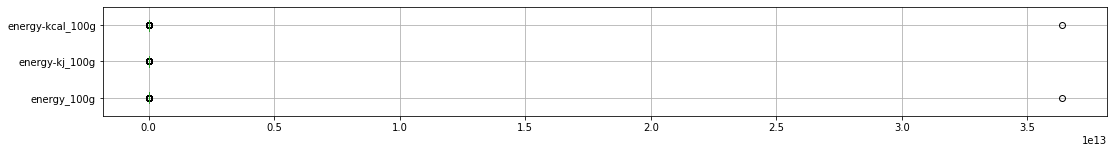

In [348]:
df_e[['energy_100g', 'energy-kj_100g', 'energy-kcal_100g']].boxplot(vert=False, figsize=(18,2));

[(-100.0, 20000.0)]

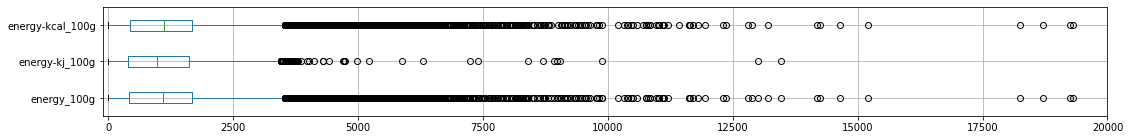

In [395]:
df_e[['energy_100g', 'energy-kj_100g', 'energy-kcal_100g']].boxplot(vert=False, figsize=(18,2));
plt.gca().set(xlim=(-100,20000))

Some outliers must be dropped. 

In [394]:
# for c in ['energy_100g', 'energy-kj_100g', 'energy-kcal_100g']:
#   arr = df_e[['energy_100g', 'energy-kj_100g', 'energy-kcal_100g']].values
#   df_e[c+'_scaled'] = (arr - np.nanmean(arr, axis=0))/np.nanstd(arr, axis=0) 

CHOISIR UN SEUIL POUR 2LIMINER LES ENERGIES

df_e[df_e['energy_100g']>10000].sample(10)

# df_e.boxplot(vert=False, figsize=(18,2))
# plt.gca().set(xlim=(0,10000))

,fat_100g,carbohydrates_100g,proteins_100g,alcohol_100g,fiber_100g,polyols_100g,energy-kj_100g,energy-kcal_100g,energy_100g,calc_energy-kcal_100g,calc_energy-kj_100g
293118,200,500,2400,nan,200,nan,nan,54392,54392,nan,nan
491505,nan,nan,nan,0,nan,nan,inf,nan,inf,nan,nan
231244,nan,nan,nan,nan,nan,nan,nan,41840,41840,nan,nan
163023,25,483,133,nan,0,nan,nan,11200,11200,2689,11251
1267969,90,3,1,nan,0,nan,13469,3467,13469,830,3474
712749,nan,1,1,nan,0,nan,nan,12803,12803,nan,nan
84519,900,nan,500,nan,nan,nan,nan,33472,33472,nan,nan
1132961,92,0,0,0,0,nan,nan,14242,14242,832,3481
1085086,19,590,33,nan,36,nan,nan,11100,11100,2728,11416
1356535,55,6,21,nan,10,nan,nan,10837,10837,626,2621


ValueError: ignored

__a) Calculating a energy_100g value from main nutritional components:__

Energy per 100g can be calculated or assessed if the data of fat, carbohydrate and proteins at least are available.

Let's get an overview of how much available data we have:

In [0]:
''' Function to count and print the number of missing values '''

def nb_rows_na(df, selcol, how):
  if how == 'all':
    ind = df[df[selcol].isna().all(axis=1)].index
  elif how == 'any':
    ind = df[df[selcol].isna().any(axis=1)].index
  else:
    ind=[]
    print("WARNING: 'how' must be either all or any")
  li_ind = ind.to_list()
  return len(li_ind), li_ind
  
def print_nb_rows_na(df, selcol, how):
  print("- columns: ", selcol, "\nnb of null containing rows (" + how + "): ", nb_rows_na(df, selcol, how)[0])

In [303]:
# Calculating the number of rows with not ANY energy OR (inclusive)
#  not ANY main nutrit. component filled
energy_cols = ['energy-kj_100g', 'energy-kcal_100g', 'energy_100g']
main_nut_comp_cols = ['fat_100g','carbohydrates_100g', 'proteins_100g']
ind_no_energy = nb_rows_na(df, energy_cols, 'all')[1]
ind_all_comp_filled = df.drop(index=nb_rows_na(df, main_nut_comp_cols, 'any')[1]).index.to_list()
ind_no_en_AND_main_comp_filled = list(set(ind_no_energy) & set(ind_all_comp_filled))
print('not any energy filled : {}\nall main nutri. components filled : {}'\
      .format(len(ind_no_energy), len(ind_all_comp_filled)))
print('not any energy filled BUT all main nutri comp filled : {}'\
      .format(len(ind_no_en_AND_main_comp_filled)))

not any energy filled : 259876
all main nutri. components filled : 1094423
not any energy filled BUT all main nutri comp filled : 1188


A majority of the rows have all main nutritional components filled.

Let's calculate the values. These will be used:
  - to fill the columns where energy_100g is missing
  - to check if the values in energy-kcal_100g and energy-kj_100g are correct

We consider all energy value per 100g lower than 0 or greater than 4000* as outliers. We erase them.
___

 \* *A product cannot be more energetic than 100g of pure fat, which energy per 100g is 900kcal or 3765kJ.*

In [0]:
## Calculating energy from composition

# 0 - creating list of columns and dictionary for coefficient (kcal/g)
nut_comp_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g',\
                 'alcohol_100g','fiber_100g', 'polyols_100g']
d_kcal = {'fat_100g': 9, 'carbohydrates_100g': 4, 'proteins_100g': 4,\
          'alcohol_100g': 7, 'fiber_100g': 1.9, 'polyols_100g': 2.4}
# 1 - creating a sub-dataframe for energy
df_e = df[energy_cols + nut_comp_cols]
# 2 - stacking all _100g values
df_melt = df_e.reset_index().melt(id_vars='index', value_vars=nut_comp_cols,\
                                  var_name='nutri_comp', value_name='kcal_100g')
# 3 - creating a column of kcal/g coefficients
df_melt['coeff'] = (df_melt['nutri_comp'].map(d_kcal)).astype('float32')
# 4 - multiplying coeff and _100g values
df_melt['calc_energy-kcal_100g'] = df_melt['kcal_100g'].mul(df_melt['coeff'])
# 5 - summing the energy for each product (index)
ser = df_melt.groupby(df_melt['index'])['calc_energy-kcal_100g'].sum()
# 6 - deleting all outliers
ser[~ser.between(0,4000)] = np.nan

In [0]:
# Inserting the new 'energy' columns in df_e, reordering columns
df_e.loc[ind_all_comp_filled,'calc_energy-kcal_100g'] = ser
df_e.loc[ind_all_comp_filled,'calc_energy-kj_100g'] = ser*4.184
# cols = move_cat_containing(df_e.columns, ['energy'],'last')
# df_e = df_e.reindex(columns=cols)

In [335]:
df_e.sample(3)

,fat_100g,carbohydrates_100g,proteins_100g,alcohol_100g,fiber_100g,polyols_100g,energy-kj_100g,energy-kcal_100g,energy_100g,calc_energy-kcal_100g,calc_energy-kj_100g
743015,28,0,22,nan,nan,nan,1410,nan,1410,340,1423
120240,0,3,3,nan,1,nan,nan,88,88,26,107
823254,46,29,13,nan,nan,nan,nan,2502,2502,582,2435


b) Now we fill missing energy when possible (enough data)

c) We can also track erroneous values by comparing calculated values with df original values

In [0]:
# Filling 'energy_100g' rows with calculated values
# df.loc[ind_no_en_AND_main_comp_filled, 'energy-kcal_100g'] = df['calc_energy-kcal_100g']
# df.loc[ind_no_en_AND_main_comp_filled, 'energy-kj_100g'] = df['calc_energy-kj_100g']

In [334]:
# sub-df of rows with at least 1 correct energy value per 100g
df_temp = df_e.dropna(how='all', subset=['energy-kj_100g',
                                       'energy-kcal_100g', 'energy_100g'])
df_temp = df_temp[(df_temp['energy-kj_100g'].between(0,4000)\
                  | df_temp['energy-kcal_100g'].between(0,4000))\
                  | df_temp['calc_energy-kcal_100g'].between(0,4000)]
df_temp['energy-kj_100g'][~df_temp['energy-kj_100g'].between(0,4000)] = np.nan
df_temp['energy-kcal_100g'][~df_temp['energy-kcal_100g'].between(0,4000)] = np.nan
df_temp['energy_100g'][~df_temp['energy_100g'].between(0,4000)] = np.nan
df_temp.shape # (1103715/1364077)

(1106149, 11)


(1106046, 11)

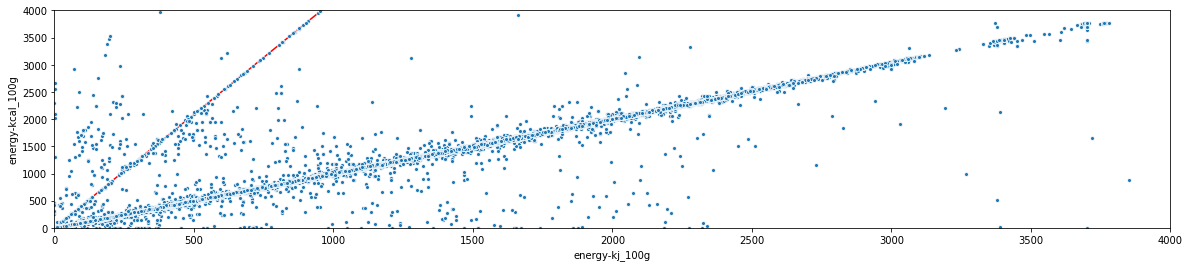

In [222]:
fig, axs = plt.subplots(1)
sns.scatterplot(data=df_temp, x='energy-kj_100g', y='energy-kcal_100g', s=15, zorder=2, ax=axs)
x_reg = np.linspace(0,10000,10)
y_reg = x_reg*4.18
axs.plot(x_reg, y_reg, '-r', zorder=1)
fig.set_size_inches(20,4)
axs.set(xlim=(0,4000), ylim=(0,4000))
plt.show()

In [396]:
@interact_manual
def plot_energy_jg(x=['energy_100g', 'energy-kj_100g', 'energy-kcal_100g', 'calc_energy-kj_100g', 'calc_energy-kcal_100g'],
                   y=['energy_100g', 'energy-kj_100g', 'energy-kcal_100g', 'calc_energy-kj_100g', 'calc_energy-kcal_100g']):
  jp = sns.jointplot(data=df_temp, x=x, y=y,
                    kind='hexbin', xlim=(0,4000), ylim=(0,4000),
                    joint_kws=dict(gridsize=50),
                    marginal_kws=dict(bins=100))
plt.show()

interactive(children=(Dropdown(description='x', options=('energy_100g', 'energy-kj_100g', 'energy-kcal_100g', …

In [0]:
'''energy from fat : si non existant reconstituer,
à partir de fat si existant mais pas fat, reconstituer fat'''

Let's now merge the new features in df.

In [0]:
# Merging df_e with df, reordering the columns
print("df before: ", df.shape,
      " | df_e: \n", df_e.shape)
df = df.merge(df_e[[XXXXXXXXXXXXXXXXXXXXXXXXXX]],
                      how = 'left',  left_index=True, right_index=True)
df = df.rename(columns = {'XXXXX':'XXXXXX',
                          'XXXXX':'XXXXXXXX',
                          'XXXXX':'XXXX'})
df = df.reindex(columns=move_cat_containing(df.columns,['energy'], 'first'))
print("df after: \n", df.shape)
# Showing df shape and column order
for i,c in enumerate(df.columns):
  print('\n'+c, end=' | ') if (i) % 6 == 0  else print(c, end=' | ')

df before:  (1366025, 99)  | df_q: 
 (375521, 7)


### 2.6 'nutriscore' columns

In [0]:
''' calcul du nutriscore à partir de la formule'''

### 2.7 'nova' column

In [0]:
'''modèle pour essayer de retrouver le nova score ?'''

## 3 Dealing with duplicates
At first we are going to deal with 'absolute' duplicates (i.e. duplicate on each row). We'll simply keep the first row.

In [0]:
# Function combining all dupl. rows,
# '1st' is the one with highest unique notna val.
''' Among each group of duplicates :
 - finds nb of unique notna for each row
 - selects the one with the most unique notna
 - combines the rows (1st is the selected row)
 - replaces all the rows by combined row
 - returns nb of grps of dupl., indexes of rows to drop, list of rows for update
 '''
def comb_dup_rows(df, cols):
  uniq_notna = lambda x:pd.notna(x.unique()).sum()
  df_f = pd.DataFrame({})
  l_ind = []
  cpt = 0
  for k,df_g in df.groupby(by=cols): # loop on all grps of dup.
    df_comb = pd.DataFrame({})
    ser_gr = df_g.apply(uniq_notna, axis=1) # nb of unique not na values
    idx_max = ser_gr.index[ser_gr.argmax()]
    ind = list(ser_gr.index)
    ind.remove(idx_max)
    df_comb = df_g.loc[idx_max]
    for i in ind: # loop on all dupl. except that with max unique not na
      df_comb = df_comb.combine_first(df_g.loc[i])
    df_f = df_f.append(df_comb)
    l_ind += ind
    cpt += 1
  df_f.reindex(columns=df.columns) #reorder the columns (bug in pd.concat)
  return cpt, l_ind, df_f 

### 3.1 Duplicates on 'code' column

Let's apply this function to df, with the subset ['code'] for the duplicates:

In [644]:
# 1 Keeping the first of duplicates on all columns
print("before", df.shape[0])
df = df[~df.duplicated(keep='first')]
print("after", df.shape[0])

before 1366025
after 1365969


Then, to deal with the duplicates on differents subsets of the columns (['code'] and key_cols), we are going to define a function that combines all the duplicated rows in one. The main row will be the one that has the greater number of unique not null values, and it will be unriched by date from the others rows if available (using pd.DataFrame.combine_first).

In [645]:
# 2 - Checking for duplicates on 'code'
df_dup = df[df.duplicated(subset=['code'],keep=False)]
print("Nb of duplicated rows on 'code':", df_dup.shape[0])

Nb of duplicated rows on 'code': 376


In [646]:
# duplicates on 'code' column
# -> Keeping the 'combined rows', deleting the others
print("Shape of df_dup, before", df_dup.shape[0])
nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup, ['code'])
df_dup = df_dup.drop(ind_drop)
df_dup.update(df_dup_f, overwrite=True)
print("Nb of groups of duplicates :", nb_gr)
print("Nb of duplicates :", df_dup.shape[0])
print("Nb of rows to delete:", len(ind_drop))
print("Shape of df_dup, after", df_dup.shape[0])

Shape of df_dup, before 376
Nb of groups of duplicates : 188
Nb of duplicates : 188
Nb of rows to delete: 188
Shape of df_dup, after 188


In [0]:
# Changing df
df = df.drop(ind_drop)
df.update(df_dup_f, overwrite=True)

In [648]:
speak('duplicates on code column dropped)')

### 3.2 Duplicates on identification key-columns

Let's apply this function to df, with the subset key_cols for the duplicates:

In [649]:
# 3 - Checking for duplicates on key_cols
key_cols = ['product_name', 'quantity_num', 'quantity_unit', 'brands']
m_dup_keys = df.duplicated(subset=key_cols,keep=False)
m_c_inval = df['code_val']==False
df_dup_k_c_val = df[m_dup_keys & ~m_c_inval]
df_dup_k_c_inval= df[m_dup_keys & m_c_inval]
print(f"Nb of duplicated rows on key_cols with VALID code: {df_dup_k_c_val.shape[0]}" )
print(f"Nb of duplicated rows on key_cols with INVALID code: {df_dup_k_c_inval.shape[0]}")

Nb of duplicated rows on key_cols with VALID code: 300869
Nb of duplicated rows on key_cols with INVALID code: 11841


If there is duplicates with different codes, and at least one of them is valid and one invalid, we want to keep only the rows with valid codes:

In [651]:
# Finding duplicates with at least 1 row with valid code AND 1 invalid code
df_mixed_dup = df[m_dup_keys].groupby(by=key_cols)\
                .filter(lambda x:sum((x['code_val']==True).values)>1\
                        and sum((x['code_val']==False).values)>1)
gb = df_mixed_dup.groupby(by=key_cols)
print(f"Nb of rows with mixed val/inval codes: {sum(gb.size())}")
print(f"Nb of groups of duplicates: {len(gb)}")

Nb of rows with mixed val/inval codes: 4
Nb of groups of duplicates: 1


In [652]:
# shows example of duplicates on key_cols with mixed 'code_val'
gb.get_group(list(gb.groups.keys())[0])

,code,code_val,url,creator,created_datetime,main_category_en,main_category,categories_en,categories,pnns_gp_2,pnns_gp_1,labels_en,quantity_type,quantity_unit,quantity_num,serving_quantity,quantity,labels,generic_name,product_name,last_modified_datetime,brand_owner,brands,packaging,origins,manufacturing_places,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_en,ingredients_text,allergens,traces_tags,traces_en,serving_size,additives_n,additives_en,...,sugars_100g,-lactose_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,caffeine_100g,cocoa_100g,phylloquinone_100g
409712,2000000020860,1,http://world-en....,desvergez,2015-08-26T13:33...,Sugars,en:sugars,"Sweeteners,Sugars","Édulcorants, Sucres",Sweets,Sugary snacks,NaN,mass,g,250,nan,250g,NaN,Sucre de fleur d...,Oriental Kiss,2017-06-23T19:46...,NaN,Lotao,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,NaN,"Allemagne, Suisse","Germany,Switzerland",NaN,NaN,NaN,NaN,NaN,nan,NaN,...,88,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
409769,2000000021150,0,http://world-en....,desvergez,2015-09-03T14:28...,Sugars,en:sugars,"Sweeteners,Sugars","Sweeteners, Sugars",Sweets,Sugary snacks,Organic,mass,g,250,nan,250g,Organic,Coconut sugar,Oriental Kiss,2017-06-17T10:42...,NaN,Lotao,NaN,NaN,NaN,NaN,NaN,NaN,"Netherlands,Austria",NaN,"Austria, Germany...","Austria,Germany,...",NaN,NaN,NaN,NaN,NaN,nan,NaN,...,88,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
409788,2000000021202,0,http://world-en....,desvergez,2015-09-04T14:43...,Sugars,en:sugars,"Sweeteners,Sugars","Sweeteners, Sugars",Sweets,Sugary snacks,Organic,mass,g,250,nan,250g,Organic,Coconut Sugar,Oriental Kiss,2017-06-17T10:37...,NaN,Lotao,NaN,NaN,NaN,NaN,NaN,NaN,Australia,NaN,"Australia, Germany","Australia,Germany",NaN,NaN,NaN,NaN,NaN,nan,NaN,...,88,nan,nan,nan,1,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
925090,4260237451303,1,http://world-en....,desvergez,2015-08-25T14:56...,Sugars,en:sugars,"Sweeteners,Sugars","Édulcorants, Sucres",Sweets,Sugary snacks,Organic,mass,g,250,nan,250g,Bio,Sucre de fleur d...,Oriental Kiss,2017-06-23T19:47...,NaN,Lotao,NaN,NaN,NaN,NaN,NaN,NaN,France,Galeries Lafayettes,"France, Allemagne","France,Germany",NaN,NaN,NaN,NaN,NaN,nan,NaN,...,88,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [653]:
# Dropping the rows with invalid codes in each group
print("Shape of df, before", df.shape[0])
for i in range(len(gb)):
  d = gb.get_group(list(gb.groups.keys())[i])
  ind = d[d['code_val']==False].index
  df.drop(index=ind, inplace=True)
print("Shape of df, after", df.shape[0])

Shape of df, before 1365781
Shape of df, after 1365779


In [667]:
# Refreshing the list
m_dup_keys = df.duplicated(subset=key_cols,keep=False)
m_c_inval = df['code_val']==False
df_dup_k_c_val = df[m_dup_keys & ~m_c_inval]
df_dup_k_c_inval= df[m_dup_keys & m_c_inval]
print(f"Nb of duplicated rows on key_cols with VALID code: {df_dup_k_c_val.shape[0]}" )
print(f"Nb of duplicated rows on key_cols with INVALID code: {df_dup_k_c_inval.shape[0]}")

Nb of duplicated rows on key_cols with VALID code: 300869
Nb of duplicated rows on key_cols with INVALID code: 11839


In [668]:
# Duplicates on key_cols column with invalid codes
# -> Keeping the combined row, deleting the others
print("Shape of df_dup_k_c_inval, before", df_dup_k_c_inval.shape[0])
nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup_k_c_inval, key_cols)
df_dup_k_c_inval = df_dup_k_c_inval.drop(ind_drop)
df_dup_k_c_inval.update(df_dup_f, overwrite=True)
print("Nb of groups of duplicates :", nb_gr)
print("Nb of duplicates :", df_dup_k_c_inval.shape[0])
print("Nb of rows to delete:", len(ind_drop))
print("Shape of df_dup_k_c_inval, after", df_dup_k_c_inval.shape[0])

Shape of df_dup_k_c_inval, before 11839
Nb of groups of duplicates : 306
Nb of duplicates : 11527
Nb of rows to delete: 312
Shape of df_dup_k_c_inval, after 11527


In [0]:
# Changing df
df.drop(ind_drop, inplace=True)
df.update(df_dup_k_c_inval, overwrite=True)

## 4 Dropping inoperable rows

We need to get rid of inoperable rows. We will define operability of a row as follows:

- condition 1: the product can be identified, at least by a unique combination of name, brand and quantity ('product_name', 'quantity', 'brands'), OR by a valid and unique barcode ('code')

AND
- condition 2: at least one numerical 'energy' columns is filled

#### *Condition 1*:

When the code is not valid, we will check if the product can be identified by a unique combination of "product_name", "quantity" and "brands". (At least one of the three must be filled).

In [0]:
key_cols = ['product_name', 'quantity', 'brands']

In [53]:
# Dropping rows with invalid codes AND all key_cols NaN
key_cols = ['product_name', 'quantity_num','quantity_unit', 'brands']
m_wo_code = df['code_val']==False
m_wo_keys = df[key_cols].isna().all(axis=1)
print("nb of rows before:", df.shape[0])
df.drop(index=df[m_wo_code & m_wo_keys].index, inplace=True)
print("nb of rows after:", df.shape[0])

nb of rows before: 1366025
nb of rows after: 1364077


In [54]:
speak('condition 1 OK')

#### *Condition 2*:

Let's now check for the second condition that is "at least one energy columns filled"

In [234]:
cond1 = df[['energy-kj_100g', 'energy-kcal_100g']].isna().all(axis=1)
cond2 = df['energy_100g'].notna()
df[cond1&cond2][['energy_100g', 'energy-kj_100g', 'energy-kcal_100g']].shape
# print(ser.shape)
# ser[ser.notna()].shape

(246, 3)

In [0]:
# df.loc[ind_all_comp_filled, sel_cols].sample(30)
df[df[main_nut_comp_cols].isna().sum(axis=1)==1][sel_cols].sample(5) # avec une valeur au moins nulle
# df.loc[ind_all_comp_filled, sel_cols].sample(30)

In [0]:
# Drop if not any energy and not any main nutri. component
ind_no_energy = nb_rows_na(df, energy_cols, 'all')[1]

In [0]:
# df[ind_no_en_AND_main_comp_filled]

In [0]:
speak('condition 2 OK')

In [0]:
df.columns[df.columns.str.contains('nova|nutri', regex=True)]

NameError: ignored

In [0]:
speak('Dropped inoperable rows')

In [0]:
# list(df.columns[df.columns.str.contains('nutri')]) 'nutriscore_score', 'nutrition-score-fr_100g'

In [0]:
# Exporting the dataframe as CSV for further treatment
df.to_csv('OFF_up_to_1_3.csv')